In [35]:
from internal import camera_utils
from internal import utils
from internal import configs
from internal import datasets
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
import open3d as o3d

In [2]:
config = configs.Config()
config.dataset_loader = 'llff'
config.near = 0.
config.far = 1.
config.factor = 8
config.data_dir = "/home/jebe/multinerf-lenses/data/fern"
config.llff_use_all_images_for_training = True
config.render_path = True
config.render_dolly_zoom = True
config.forward_facing = True
config.render_path_frames = 10
dataset1 = datasets.load_dataset('test', config.data_dir, config)

Casting ray batch in test mode (CPU).
Casting ray batch in test mode (CPU).


In [33]:
def line(ax, p, q, color="r"):
  """Plots a 3d line between points p and q."""
  x = [p[0], q[0]]
  y = [p[1], q[1]]
  z = [p[2], q[2]]
  ax.plot(x, y, zs=z, color=color)

def plot_rays(rays, length=1, scale=50):
    
  origins = rays.origins[::scale, ::scale, :]
  directions = rays.directions[::scale, ::scale, :]
  imageplane = rays.imageplane[::scale, ::scale, :]
    
    
  fig = plt.figure(figsize=plt.figaspect(0.5))
  ax = fig.add_subplot(1, 1, 1, projection='3d')
    
  x = origins[..., 0].reshape((-1,))
  y = origins[..., 1].reshape((-1,))
  z = origins[..., 2].reshape((-1,))
  ax.scatter3D(x, y, z, c=np.linspace(0, 1, np.prod(x.shape[:2])), cmap='viridis', marker='o', s=50, alpha=0.7)
    
  xi = imageplane[..., 0].reshape((-1,))
  yi = imageplane[..., 1].reshape((-1,))
  zi = np.ones_like(xi)
  ax.scatter3D(xi, yi, zi, c=np.linspace(0, 1, np.prod(x.shape[:2])), cmap='viridis', marker='o', s=10, alpha=0.7)

  directions = directions.reshape((-1,3))
  origins = origins.reshape((-1,3))
  for o, d in zip(origins, directions):
    line(ax, o, o+d, color="b")
    
  ax.set_xlabel("X")
  ax.set_ylabel("Y")
  ax.set_zlabel("Z")

def pixels_to_rays(
    pix_x_int,
    pix_y_int,
    pixtocams,
    camtoworlds,
    pixtocam_ndc = None,
    xnp = np,
):

  # Must add half pixel offset to shoot rays through pixel centers.
  def pix_to_dir(x, y):
    return xnp.stack([x + .5, y + .5, xnp.ones_like(x)], axis=-1)

  # We need the dx and dy rays to calculate ray radii for mip-NeRF cones.
  pixel_dirs_stacked = xnp.stack([
      pix_to_dir(pix_x_int, pix_y_int),
      pix_to_dir(pix_x_int + 1, pix_y_int),
      pix_to_dir(pix_x_int, pix_y_int + 1)
  ],
                                 axis=0)

  # For jax, need to specify high-precision matmul.
  mat_vec_mul = lambda A, b: xnp.matmul(A, b[..., None])[..., 0]

  # Apply inverse intrinsic matrices.
  camera_dirs_stacked = mat_vec_mul(pixtocams, pixel_dirs_stacked)

  # Flip from OpenCV to OpenGL coordinate system.
  camera_dirs_stacked = xnp.matmul(camera_dirs_stacked,
                               xnp.diag(xnp.array([1., -1., -1.])))

  # Extract 2D image plane (x, y) coordinates.
  imageplane = camera_dirs_stacked[0, ..., :2]

  # Apply camera rotation matrices.
  directions_stacked = mat_vec_mul(camtoworlds[..., :3, :3],
                                   camera_dirs_stacked)
  # Extract the offset rays.
  directions, dx, dy = directions_stacked

  origins = xnp.broadcast_to(camtoworlds[..., :3, -1], directions.shape)
  viewdirs = directions / xnp.linalg.norm(directions, axis=-1, keepdims=True)

  if pixtocam_ndc is None:
    # Distance from each unit-norm direction vector to its neighbors.
    dx_norm = xnp.linalg.norm(dx - directions, axis=-1)
    dy_norm = xnp.linalg.norm(dy - directions, axis=-1)

  else:
    # Convert ray origins and directions into projective NDC space.
    origins_dx, _ = convert_to_ndc(origins, dx, pixtocam_ndc)
    origins_dy, _ = convert_to_ndc(origins, dy, pixtocam_ndc)
    origins, directions = convert_to_ndc(origins, directions, pixtocam_ndc)
    # origins_dx, _ = convert_to_ndcs(origins, dx, pixtocams)
    # origins_dy, _ = convert_to_ndcs(origins, dy, pixtocams)
    # origins, directions = convert_to_ndcs(origins, directions, pixtocams)

    # In NDC space, we use the offset between origins instead of directions.
    dx_norm = xnp.linalg.norm(origins_dx - origins, axis=-1)
    dy_norm = xnp.linalg.norm(origins_dy - origins, axis=-1)

  # Cut the distance in half, multiply it to match the variance of a uniform
  # distribution the size of a pixel (1/12, see the original mipnerf paper).
  radii = (0.5 * (dx_norm + dy_norm))[..., None] * 2 / xnp.sqrt(12)

  return origins, directions, viewdirs, radii, imageplane

In [30]:
rays0 = dataset1.generate_ray_batch(0).rays
rays1 = dataset1.generate_ray_batch(1).rays
rays9 = dataset1.generate_ray_batch(9).rays

Casting ray batch in test mode (CPU).
Casting ray batch in test mode (CPU).
Casting ray batch in test mode (CPU).


In [31]:
print(rays0.origins.shape)
print(rays0.directions.shape)
# print(rays0.directions[0, 0, :])
# print(rays0.directions[150, 150, :])
print(rays0.directions[-1, -1, :])
# print(dataset1.pixtocams[0])
# print(dataset1.pixtocams[1])
# print(np.min(dataset1.pixels.pix_x_int))
# print(np.max(dataset1.pixels.pix_x_int))
# print(np.min(dataset1.pixels.pix_y_int))
# print(np.max(dataset1.pixels.pix_y_int))
print(dataset1.cameras[0][0]) # Pixtocams
print(dataset1.cameras[2]) # Distortion

(378, 504, 3)
(378, 504, 3)
[ 0.61707832 -0.46250204 -1.        ]
[[ 0.00245359  0.         -0.6183051 ]
 [ 0.          0.00245359 -0.46372882]
 [ 0.          0.          1.        ]]
None


[[407.56577   0.      252.     ]
 [  0.      407.56577 189.     ]
 [  0.        0.        1.     ]]
[[543.421   0.    336.   ]
 [  0.    543.421 252.   ]
 [  0.      0.      1.   ]]


<IPython.core.display.Javascript object>


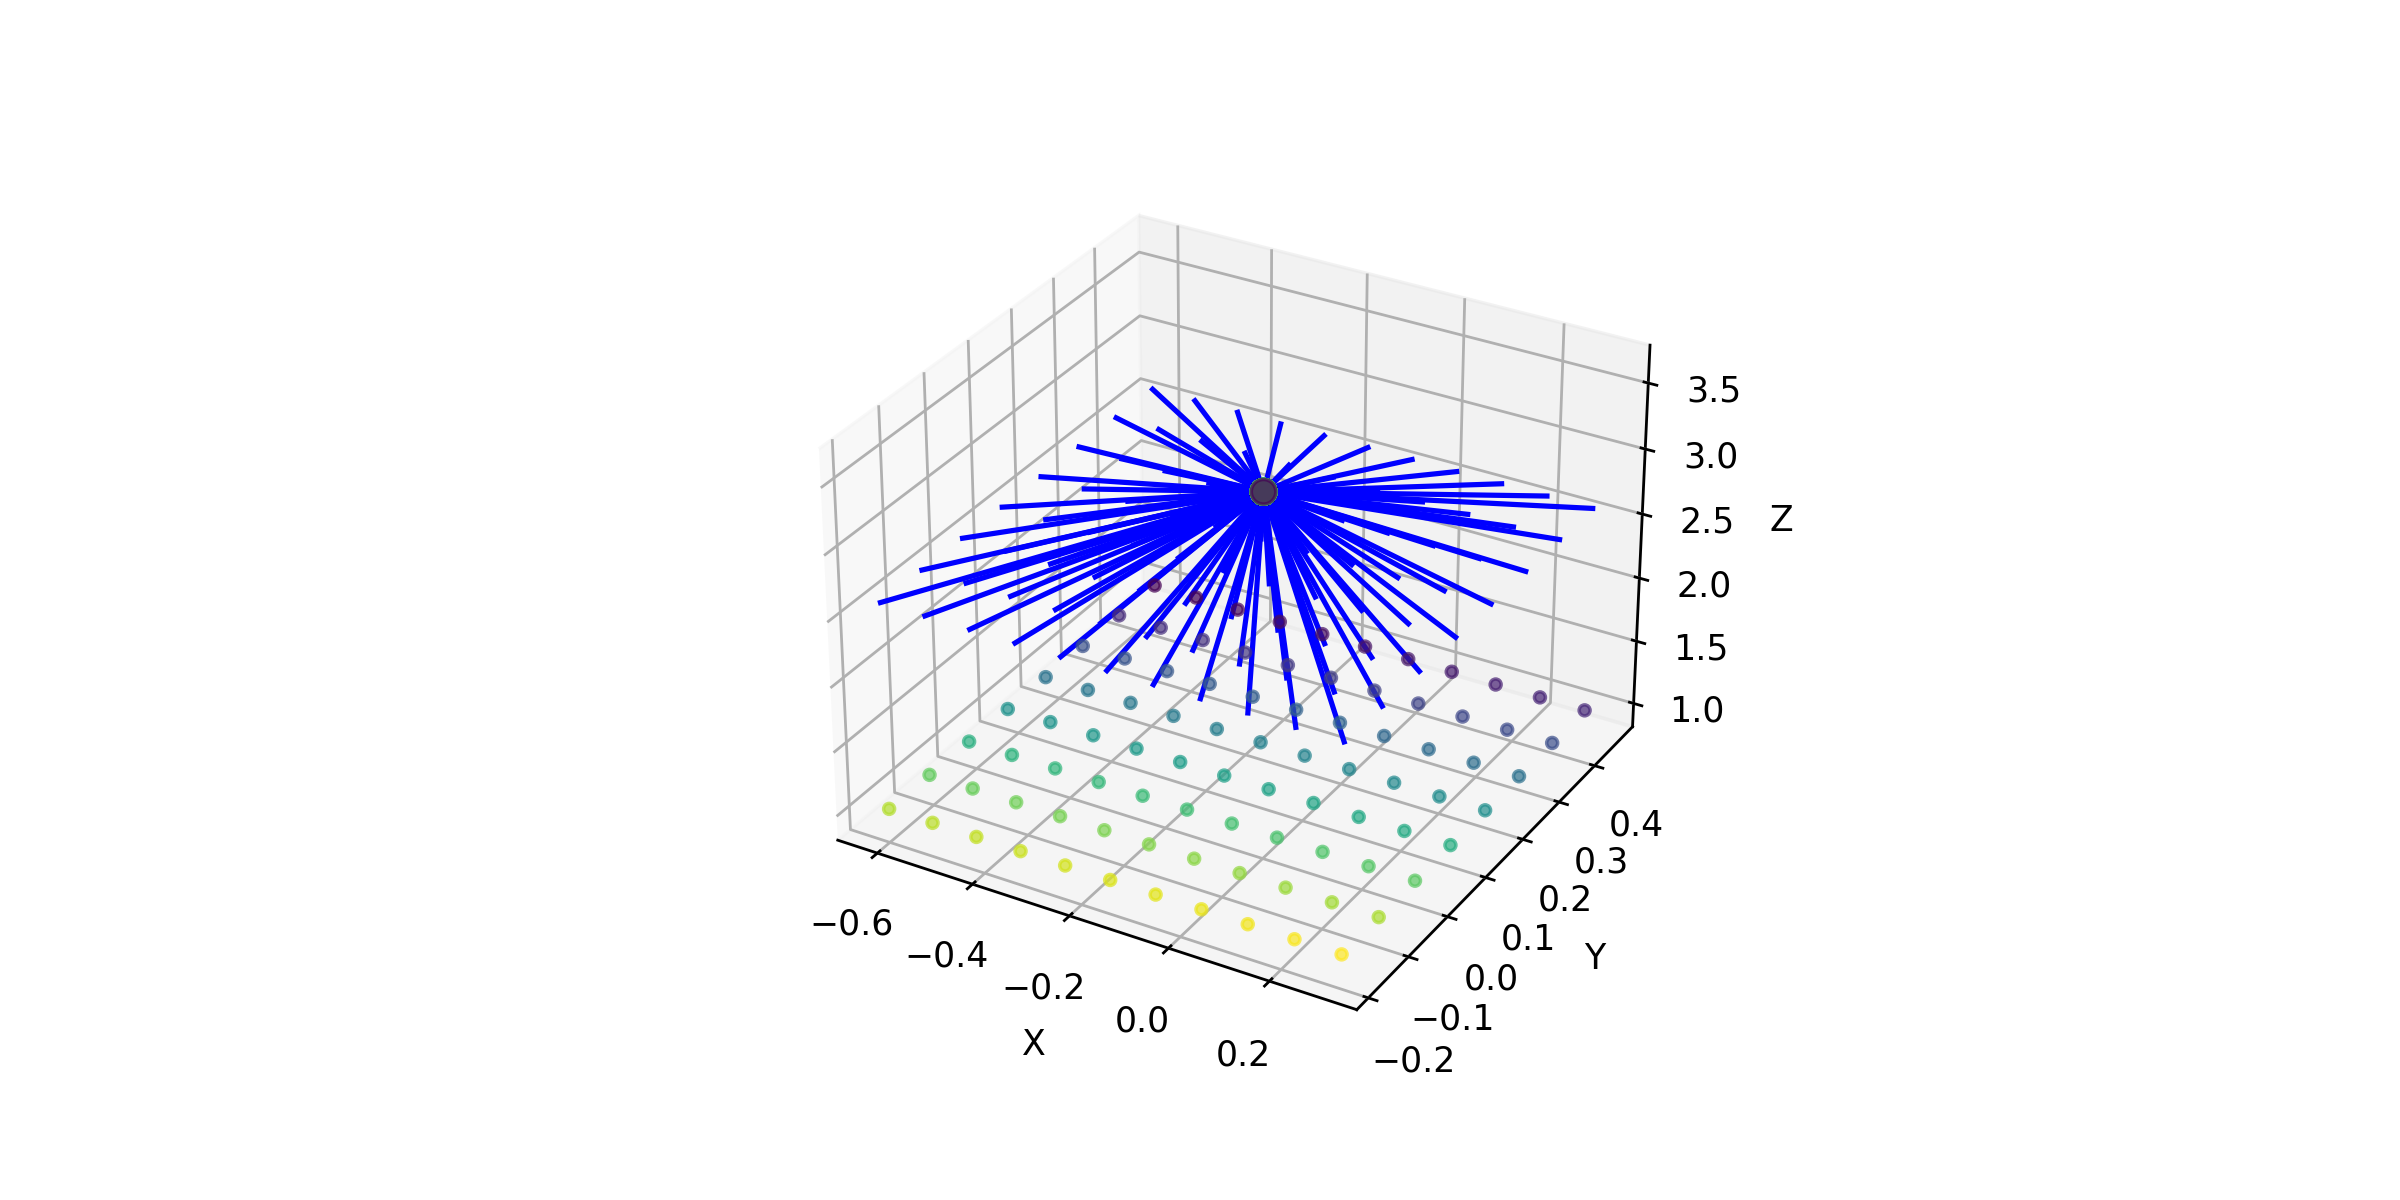

In [44]:
index = 1
pixels = dataset1.pixels

# Test pixtocam effect.
pixtocam = dataset1.pixtocams[0]
print(np.linalg.inv(pixtocam))
pixtocam = dataset1.pixtocams[1]
print(np.linalg.inv(pixtocam))

origins, directions, viewdirs, radii, imageplane = pixels_to_rays(
      pixels.pix_x_int,
      pixels.pix_y_int,
      pixtocam,
      dataset1.camtoworlds[index])

rays = utils.Rays(
      origins=origins,
      directions=directions,
      viewdirs=viewdirs,
      radii=radii,
      imageplane=imageplane,
      lossmult=pixels.lossmult,
      near=pixels.near,
      far=pixels.far,
      cam_idx=pixels.cam_idx,
      exposure_idx=pixels.exposure_idx,
      exposure_values=pixels.exposure_values,
  )
%matplotlib notebook
plot_rays(rays)

<IPython.core.display.Javascript object>


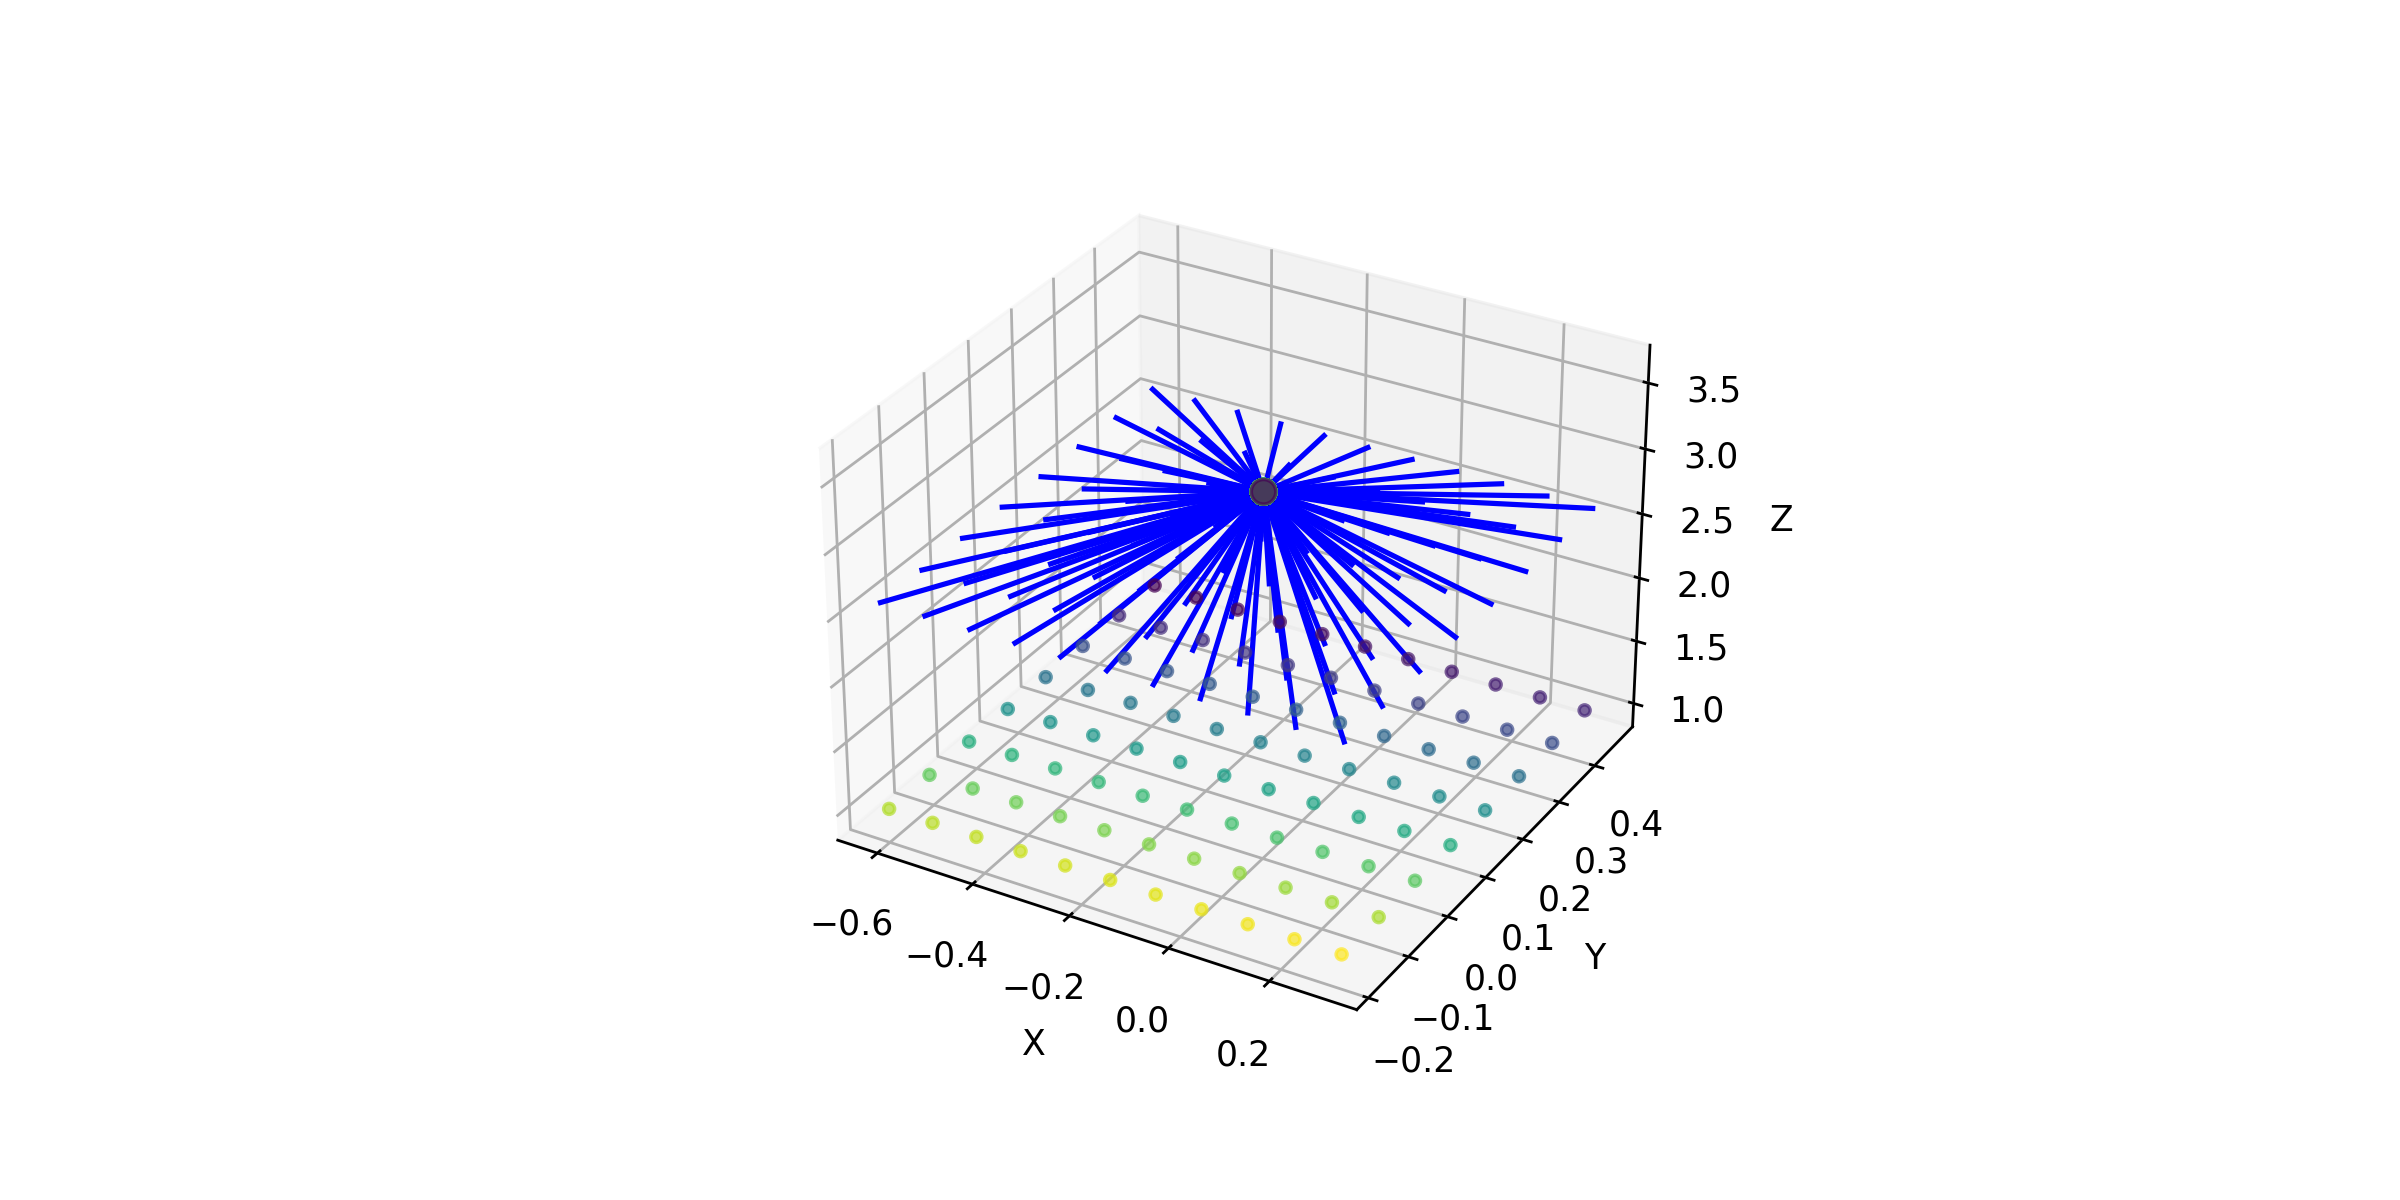

In [7]:
%matplotlib notebook
plot_rays(rays1)